# Проект для «Викишоп» с BERT with CUDA

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

**Подключение библиотек**

In [152]:
import pandas as pd
import numpy as np
import torch
import transformers 
import ast # для преобразования строк в списки при загрузке csv файла
import os # для работы с файловой системой
import re # regular expressions

import timeit
from tqdm import notebook # визуализация прогресса
import lightgbm as lgb
from catboost import CatBoostClassifier

from torch import nn
from torch.optim import SGD

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

---
**Глобальные настройки**

In [2]:
OUTPUT_FOLDER = 'output' # папка с калькулированными данными
MAX_TOKENS = 512 # ограничение BERT на цепочку токенов 512
BERT_BATCH_SIZE = 30  # размер батча для ембеддинга через BERT. Ограничил под видеопамять 6GB
MAX_ROWS = 159292 # количество строк в выборке.   159292
CUDA = torch.cuda.is_available() # используем ли расчеты на GPU. На MacOS не заработает.

In [3]:
# Создадим директорию для сохранения промежуточных результатов.
if not os.path.exists(OUTPUT_FOLDER):
    os.mkdir(OUTPUT_FOLDER)
    print("Directory " , OUTPUT_FOLDER ,  " Created ")
else:    
    print("Directory " , OUTPUT_FOLDER ,  " already exists")

Directory  output  already exists


---
**Импорт данных**

In [4]:
try:
    data = pd.read_csv('toxic_comments.csv', index_col=[0])  # локальная версия
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])   # сетевая версия

In [5]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [6]:
print('Изначальная выгрузка:', data.shape)
data = data[:MAX_ROWS]
print('После ограничения по MAX_ROWS:', data.shape)

Изначальная выгрузка: (159292, 2)
После ограничения по MAX_ROWS: (159292, 2)


---
**Очистка текста от спецсимволов**

In [7]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z\'\,\.\! ]', ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

print(data.head())
#data['text'] = data['text'].apply(clear_text).str.lower()
print(data.head())

                                                text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0
                                                text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0


С очисткой BERT работает только хуже.

---
**Инициализируем классы BERT**

In [8]:
# инициализируем классы предобученной модели BERT
#model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased') 
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'unitary/toxic-bert') 

# токенизатор
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, do_lower_case=True)

# предобученная модель BERT
model = model_class.from_pretrained(pretrained_weights)

# переключаем модель на GPU расчет. 
if CUDA:
    model = model.cuda()

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


---
**Токенизация**

In [9]:
%%time
tokens_file_path = f"{OUTPUT_FOLDER}/tokens_{MAX_ROWS}.csv"

try:
    df = pd.read_csv(tokens_file_path, index_col=[0])['text'] # подгрузим ранее сгенерированные токены 
    tokenized = pd.Series([ast.literal_eval(row) for row in df.values]) # преобразуем в Series of List
    print(f'Токены загружены из "{tokens_file_path}" ({round( os.path.getsize(tokens_file_path)/1024/1024 ,2)} Mb)')
    
except:
    # сгенерируем токены, если не сохранены ранее сгенерированные
    tokenized = data['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    tokenized.to_csv(tokens_file_path)
    print(f'Токены сохранены как "{tokens_file_path}" ({round( os.path.getsize(tokens_file_path)/1024/1024 ,2)} Mb)')

print(f'type {type(tokenized)}')
print(f'shape {tokenized.shape}')
print('-'*10)

Токены загружены из "output/tokens_159292.csv" (88.98 Mb)
type <class 'pandas.core.series.Series'>
shape (159292,)
----------
Wall time: 27.4 s


<AxesSubplot:>

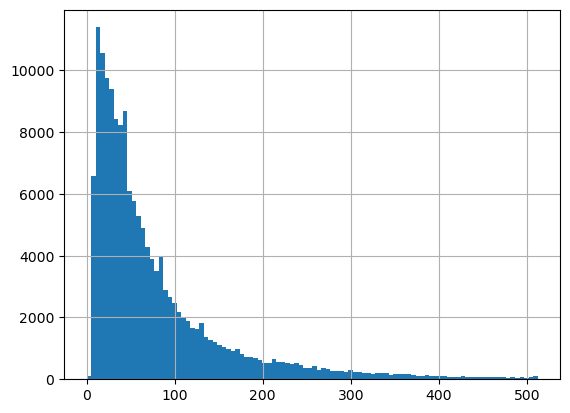

In [10]:
# посмотрим на распределение длин сообщений
tokenized.apply((lambda x: len(x))).hist(bins=100, range=(0,512) )

В некоторых случаях список токенов слов превышает установленный параметр MAX_TOKENS. Обрежем слишком длинные списки. Слишком короткие дополним нулевыми токенами до размера MAX_TOKENS.

In [11]:
# обрежем слишком длинные цепочки токенов
padded = [i[:MAX_TOKENS-1] + [102] for i in tokenized]

# дополним слишком короткие цепочки нулевыми токенами
padded = np.array([i + [0]*(MAX_TOKENS-len(i)) for i in padded])

In [12]:
# создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)

---
**Embedding предложений**

In [13]:
embeddings = []
    
# генерация батчами в цикле
for i in notebook.tqdm(range(padded.shape[0] // BERT_BATCH_SIZE + 1)): 

    file_path = f"{OUTPUT_FOLDER}/embedding_{BERT_BATCH_SIZE}_{i:06d}.csv"
    
    try:
        # пробуем подгрузить файл по имени
        result = np.array(pd.read_csv(file_path, index_col=[0]))
        embeddings.append(result) 
        
    except:
        # файл не найден - вычисляем embedding для батча и сохраняем его в файл
        
        if CUDA:
            # создаем тензоры входных данных и маски на GPU
            batch = torch.LongTensor(padded[BERT_BATCH_SIZE*i:BERT_BATCH_SIZE*(i+1)]).cuda()
            attention_mask_batch = torch.LongTensor(attention_mask[BERT_BATCH_SIZE*i:BERT_BATCH_SIZE*(i+1)]).cuda()
        else:
            # создаем тензоры входных данных и маски на CPU
            batch = torch.LongTensor(padded[BERT_BATCH_SIZE*i:BERT_BATCH_SIZE*(i+1)])
            attention_mask_batch = torch.LongTensor(attention_mask[BERT_BATCH_SIZE*i:BERT_BATCH_SIZE*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        # сохраним результат
        result = batch_embeddings[0][:,0,:].cpu() # возврат результата из GPU Memory -> RAM
        result = result.numpy()
        pd.DataFrame(result).to_csv(file_path)
        
        # добавим результат батча к списку эмбеддингов
        embeddings.append(result) 


  0%|          | 0/5310 [00:00<?, ?it/s]

**Промежуточные выводы:**
1. импорт данных прошел без проблем
2. была развернута предварительно обученная модель `unitary/toxic-bert`
3. ввиду длительного расчета моделью BERT и случающихся ошибок с перезагрузкой Kernel, были осуществлены следующие шаги:
    - создана папка и механизм сохранения в нее промежуточных данных токенизации и эмбеддинга
    - перед запуском просчета токенизации и эмбеддинга проводится проверка наличия в папке ранее полученных результатов
    - непосредственно запуск расчетов производится только при отсутствии ранее полученных результатов
4. для значительного ускорения расчетов применен механизм вычислений на видеокарте (CUDA)
    - в начале работы проверяется доступность CUDA командой torch.cuda.is_available()
    - если CUDA активна, все последующий действия с BERT (создание модели, входящих тензоров и получение результата) проводятся на GPU 
    - итоговый прирост скорости более, чем в 40 раз (**20+ часов** на `CPU AMD Ryzen 5 2600 6 Core` против **0.5 часа** на GPU `Geforce RTX 2060`)
5. токенизация:
    - были выявлены слишком длинные цепочки токенов, более 512 в ряд. В таких случаях они обрезались до 511 с обязательным добавлением в конце токена [102] 
    - для цепочек токенов < 512 недостающие токены заполнены [0]
6. эмбеддинг:
    - запускаем небольшими батчами
    - для каждого батча создается тензор входящих данных для расчета и маска для важных токенов
    - пересчет батчей проводится на CPU / GPU в зависимости от конфигурации устройства
    - результаты пересчета сохраняются в csv файл формата `embedding_{размер_батча}_{номер_батча}.csv`
    - суммарный размер всех полученных файлов ~ 1.48 Gb

## Обучение

**Подготовка обучающей и тестовой выборок**

In [14]:
# подготовим выборки признаков и целевого признака
target = data['toxic'][:MAX_ROWS]
features = pd.DataFrame(np.concatenate(embeddings), index = target.index)

In [15]:
print('features shape', features.shape)
print('target shape', target.shape)

features shape (159292, 768)
target shape (159292,)


In [16]:
# разделение на обучающую и тестовую выборку
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.1, 
                                                                            random_state=0 , 
                                                                            stratify=target )

<AxesSubplot:>

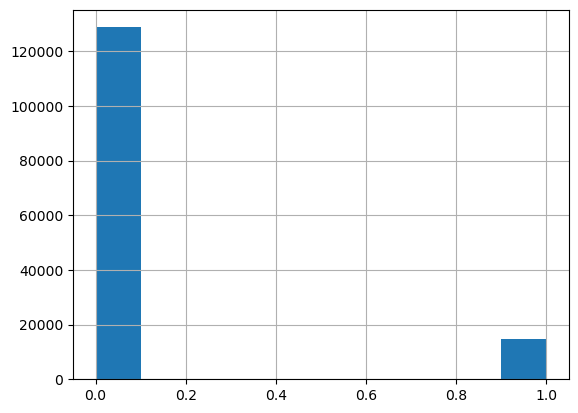

In [17]:
# проверим баланс классов в тренировочной выборке
target_train.hist()

In [18]:
# баланс смещен в сторону отсутствия токсичности в комментариях
# сбалансируем классы
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train, target_train = upsample(features_train, target_train, 8)

---
**Обучение нескольких разных моделей классификации**

In [19]:
models = []

In [30]:
def remember_model(model, best_params, score_train):
    print('-'*50)
    print('Model:', type(model))
    print('\nF1 train: %.4f'% score_train, ' Best Params : ', str(best_params))
    print()
    models.append([model, type(model), best_params, score_train])  

<font color='darkblue' style="font-weight:bold">CatBoostClassifier</font>

In [21]:
%%time
# проведен GridSearchCV с перебором параметров
# param_grid = {'learning_rate': [0.03, 0.1],'depth': [4, 6, 10],'l2_leaf_reg': [1, 3, 5, 7, 9]}
# F1 train: 0.9932  Best Params :  {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
# оставлен лучший вариант для ускорения пересчетов
grid = GridSearchCV(CatBoostClassifier(iterations=200,random_seed=0, task_type="GPU", devices='0'), 
                    param_grid = {'learning_rate': [0.1],'depth': [10],'l2_leaf_reg': [1]},
                    cv = 5,
                    scoring = 'f1',
                    verbose=5,
                    n_jobs=2)

grid.fit(features_train, target_train)

remember_model(grid.best_estimator_, grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0:	learn: 0.4635874	total: 210ms	remaining: 41.8s
1:	learn: 0.3189359	total: 327ms	remaining: 32.4s
2:	learn: 0.2247500	total: 446ms	remaining: 29.3s
3:	learn: 0.1653022	total: 565ms	remaining: 27.7s
4:	learn: 0.1261982	total: 681ms	remaining: 26.6s
5:	learn: 0.1008546	total: 793ms	remaining: 25.6s
6:	learn: 0.0839351	total: 913ms	remaining: 25.2s
7:	learn: 0.0720883	total: 1.03s	remaining: 24.6s
8:	learn: 0.0633999	total: 1.14s	remaining: 24.1s
9:	learn: 0.0572397	total: 1.24s	remaining: 23.6s
10:	learn: 0.0531891	total: 1.34s	remaining: 23.1s
11:	learn: 0.0499588	total: 1.45s	remaining: 22.7s
12:	learn: 0.0475681	total: 1.55s	remaining: 22.4s
13:	learn: 0.0455733	total: 1.65s	remaining: 22s
14:	learn: 0.0441830	total: 1.75s	remaining: 21.6s
15:	learn: 0.0430881	total: 1.85s	remaining: 21.3s
16:	learn: 0.0419986	total: 1.95s	remaining: 21s
17:	learn: 0.0409576	total: 2.05s	remaining: 20.8s
18:	learn: 0.0401467	total: 2.15s	

<font color='darkblue' style="font-weight:bold">LogisticRegression</font>

In [31]:
%%time
grid = GridSearchCV(LogisticRegression(), 
                    param_grid = {'C': [1.0]},
                    cv = 5,
                    scoring = 'f1',
                    verbose=1,
                    n_jobs=2)

grid.fit(features_train, target_train)

remember_model(grid.best_estimator_, grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
--------------------------------------------------
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>

F1 train: 0.9844  Best Params :  {'C': 1.0}

Wall time: 1min 19s


<font color='darkblue' style="font-weight:bold">RidgeClassifier</font>

In [32]:
%%time
grid = GridSearchCV(RidgeClassifier(), 
                    param_grid = {'alpha': [1.0]},
                    cv = 5,
                    scoring = 'f1',
                    verbose=1,
                    n_jobs=2)

grid.fit(features_train, target_train)

remember_model(grid.best_estimator_, grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
--------------------------------------------------
Model: <class 'sklearn.linear_model._ridge.RidgeClassifier'>

F1 train: 0.9827  Best Params :  {'alpha': 1.0}

Wall time: 32.3 s


<font color='darkblue' style="font-weight:bold">DecisionTreeClassifier</font>

In [33]:
%%time
# проведен GridSearchCV с перебором параметров
# param_grid = {'max_depth': [2,5,10]}
# F1 train: 0.9885  Best Params :  {'max_depth': 10}
# оставлен лучший вариант для ускорения пересчетов
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                    param_grid = {'max_depth': [10]},
                    cv = 5,
                    scoring = 'f1',
                    verbose=5,
                    n_jobs=6)

grid.fit(features_train, target_train)

remember_model(grid.best_estimator_, grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
--------------------------------------------------
Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>

F1 train: 0.9885  Best Params :  {'max_depth': 10}

Wall time: 8min 14s


<font color='darkblue' style="font-weight:bold">RandomForestClassifier</font>

In [34]:
%%time
# проведен GridSearchCV с перебором параметров
# param_grid = {'max_depth': [2,5,10,20], 'n_estimators': [10,100, 500],},
# F1 train: 0.9944  Best Params :  {'max_depth': 20, 'n_estimators': 10}
# оставлен лучший вариант для ускорения пересчетов

grid = GridSearchCV(RandomForestClassifier(random_state=0),
                    param_grid = {'max_depth': [20], 'n_estimators': [10],},
                    cv = 5,
                    scoring = 'f1',
                    verbose=5,
                    n_jobs=6)

grid.fit(features_train, target_train)

remember_model(grid.best_estimator_, grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
--------------------------------------------------
Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

F1 train: 0.9944  Best Params :  {'max_depth': 20, 'n_estimators': 10}



<font color='darkblue' style="font-weight:bold">LightBGM</font>

In [ ]:
# происходит краш системы, видимо не хватает оперативной памяти.
'''%%time
grid = GridSearchCV(lgb.LGBMClassifier(random_state=0),
                    param_grid = {'max_depth': [2,5,10, 20], 'n_estimators': [100,200, 500], 'learning_rate':[0.01, 0.1, 1]},
                    cv = 5,
                    scoring = 'f1',
                    verbose=5,
                    n_jobs=4)

grid.fit(features_train, target_train)

remember_model(grid.best_estimator_, grid.best_params_, grid.best_score_)'''

<font color='darkblue' style="font-weight:bold">Pytorch NN classifier</font>

In [42]:
# преобразуем выборки в тензоры pytorch
X_train, X_test, Y_train, Y_test = torch.tensor(features_train.values, dtype=torch.float32),\
                                   torch.tensor(features_test.values, dtype=torch.float32),\
                                   torch.tensor(target_train.values, dtype=torch.long),\
                                   torch.tensor(target_test.values, dtype=torch.long)

samples, features = X_train.shape
classes = Y_test.unique()

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([245331, 768]),
 torch.Size([15930, 768]),
 torch.Size([245331]),
 torch.Size([15930]))

In [43]:
samples, features, classes

(245331, 768, tensor([0, 1]))

In [127]:
# создаем класс нейронной сети. 
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.first_layer = nn.Linear(features, 100)
        self.final_layer = nn.Linear(100,2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X_batch):
        layer_out = self.relu(self.first_layer(X_batch))
        #layer_out = self.relu(self.second_layer(layer_out))
        #layer_out = self.relu(self.third_layer(layer_out))
        return self.softmax(self.final_layer(layer_out))

In [128]:
classifier = Classifier()

In [136]:
# функция обучения нейросети
def TrainModel(model, loss_func, optimizer, X, Y, epochs=500):
    for i in range(epochs):
        preds = model(X).squeeze() # [:,0] ## Make Predictions by forward pass through network
        
        loss = loss_func(preds, Y) ## Calculate Loss

        optimizer.zero_grad() ## Zero weights before calculating gradients
        loss.backward() ## Calculate Gradients
        optimizer.step() ## Update Weights

        if i % 50 == 0: ## Print loss every 50 epochs
            print("epoch:" , i , "\tNLLLoss : {:.4f}".format(loss))

In [137]:
%%time

torch.manual_seed(42) ##For reproducibility.This will make sure that same random weights are initialized each time.

epochs = 300
learning_rate = torch.tensor(0.01) # 0.01

classifier = Classifier()
nll_loss = nn.NLLLoss()
bce_loss = nn.BCELoss()
optimizer = SGD(params=classifier.parameters(), lr=learning_rate)

# тренируем модель
TrainModel(classifier, nll_loss, optimizer, X_train, Y_train, epochs=epochs)

# получаем предсказания на трейне и тесте
test_preds = classifier(X_test) ## Make Predictions on test dataset
test_preds = torch.argmax(test_preds, axis=1) ## Convert Probabilities to class type

train_preds = classifier(X_train) ## Make Predictions on train dataset
train_preds = torch.argmax(train_preds, axis=1) ## Convert Probabilities to class type

remember_model(classifier, {'epochs':epochs, 'learning_rate':learning_rate}, f1_score(Y_train, train_preds))

epoch: 0 	NLLLoss : -0.5297
epoch: 50 	NLLLoss : -0.9036
epoch: 100 	NLLLoss : -0.9470
epoch: 150 	NLLLoss : -0.9589
epoch: 200 	NLLLoss : -0.9643
epoch: 250 	NLLLoss : -0.9675
Wall time: 4min 41s


---
**Определение лучшей модели**

In [175]:
df_models = pd.DataFrame(models, columns=['model', 'type(model)', 'best_params', 'score_train'])
display(df_models.sort_values('score_train', ascending=False))

,model,type(model),best_params,score_train
4,"(DecisionTreeClassifier(max_depth=20, max_feat...",<class 'sklearn.ensemble._forest.RandomForestC...,"{'max_depth': 20, 'n_estimators': 10}",0.994406
0,<catboost.core.CatBoostClassifier object at 0x...,<class 'catboost.core.CatBoostClassifier'>,"{'depth': 10, 'l2_leaf_reg': 1, 'learning_rate...",0.993196
3,"DecisionTreeClassifier(max_depth=10, random_st...",<class 'sklearn.tree._classes.DecisionTreeClas...,{'max_depth': 10},0.988509
1,LogisticRegression(),<class 'sklearn.linear_model._logistic.Logisti...,{'C': 1.0},0.984407
2,RidgeClassifier(),<class 'sklearn.linear_model._ridge.RidgeClass...,{'alpha': 1.0},0.982747
5,Classifier(\n (first_layer): Linear(in_featur...,<class '__main__.Classifier'>,"{'epochs': 300, 'learning_rate': tensor(0.0100)}",0.979909


Лучшая модель по метрике F1 - `DecisionTreeClassifier`

---
**Проверка работы лучших моделей**

In [191]:
df_models['score_test'] = 0

In [192]:
for i in range(len(df_models)):
    if type(df_models.loc[i]['model']) == type(classifier):
        df_models.at[i, 'score_test'] = f1_score(Y_test, test_preds)
    else:
        df_models.at[i, 'score_test'] = f1_score(target_test, df_models.loc[i]['model'].predict(features_test))

In [195]:
# отобразим лучшую модель
df_models.loc[[4],['model', 'best_params', 'score_train', 'score_test']].sort_values('score_train', ascending=False)

,model,best_params,score_train,score_test
4,"(DecisionTreeClassifier(max_depth=20, max_feat...","{'max_depth': 20, 'n_estimators': 10}",0.994406,0.938973


## Выводы

**Подготовка модели BERT:**
1. импорт данных прошел без проблем
2. была развернута предварительно обученная модель `unitary/toxic-bert`
3. ввиду длительного расчета моделью BERT и случающихся ошибок с перезагрузкой Kernel, были осуществлены следующие шаги:
    - создана папка и механизм сохранения в нее промежуточных данных токенизации и эмбеддинга
    - перед запуском просчета токенизации и эмбеддинга проводится проверка наличия в папке ранее полученных результатов
    - непосредственно запуск расчетов производится только при отсутствии ранее полученных результатов
4. для значительного ускорения расчетов применен механизм вычислений на видеокарте (CUDA)
    - в начале работы проверяется доступность CUDA командой torch.cuda.is_available()
    - если CUDA активна, все последующий действия с BERT (создание модели, входящих тензоров и получение результата) проводятся на GPU 
    - итоговый прирост скорости более, чем в 40 раз (**20+ часов** на `CPU AMD Ryzen 5 2600 6 Core` против **0.5 часа** на GPU `Geforce RTX 2060`)
5. токенизация:
    - были выявлены слишком длинные цепочки токенов, более 512 в ряд. В таких случаях они обрезались до 511 с обязательным добавлением в конце токена [102] 
    - для цепочек токенов < 512 недостающие токены заполнены [0]
6. эмбеддинг:
    - запускаем небольшими батчами
    - для каждого батча создается тензор входящих данных для расчета и маска для важных токенов
    - пересчет батчей проводится на CPU / GPU в зависимости от конфигурации устройства
    - результаты пересчета сохраняются в csv файл формата `embedding_{размер_батча}_{номер_батча}.csv`
    - суммарный размер всех полученных файлов ~ 1.48 Gb

**Обучение моделей классификации:**
1. Выборка разделена на обучающую/тестовую в соотношении 90/10
2. В выборке наблюдается дисбаланс классов, примерно 8 к 1
3. Обучающая выборка была сбалансирована методом апсемплинга.
4. был обучен широкий набор моделей
    - Модель LogisticRegression 
    - Модель RidgeClassifier 
    - Модель RandomForestClassifier 
    - Модель DecisionTreeClassifier 
    - Модель CatBoostClassifier
    - Нейросеть на pytorch
5. Лучшая модель по метрике F1 - DecisionTreeClassifier с параметрами {'max_depth': 20, 'n_estimators': 10}
6. Результат метрики F1 на тестовой выборке 0.938973